## Example of how to compute metrics for measuring fidelity of simulation

In [1]:
import numpy as np
import pandas as pd
import gym
from tqdm import tqdm
import joblib
from joblib import Parallel, delayed
from collections import Counter

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
matplotlib.rcParams['font.sans-serif'] = ['Arial']
%config InlineBackend.figure_formats = ['svg']

In [3]:
from offsim4rl.agents import tabular
from offsim4rl.envs import gridworld

In [4]:
# a small helper class for constructing tabular MDP with transition and reward functions
import gym.envs.toy_text.discrete
class MDP_Env(gym.envs.toy_text.discrete.DiscreteEnv):
    def __init__(self, p_transition, p_reward, S_terminal, isd=None):
        self.np_random = np.random.default_rng()
        nS, nA, _ = p_transition.shape
        if isd is None:
            isd = np.ones(nS)
            isd = isd / isd.sum()
        
        P = {s : {a : [] for a in range(nA)} for s in range(nS)}
        for s in range(nS):
            for a in range(nA):
                for s_ in range(nS):
                    if p_transition[s,a,s_] > 0:
                        P[s][a].append((p_transition[s,a,s_], s_, p_reward[s,a,s_], s_ in S_terminal))
        super().__init__(nS, nA, P, isd)
    
    def reset(self, seed=None):
        return super().reset()

In [5]:
N_logging_episodes = 1000
N_simulate_runs = 100
N_simulate_episodes = 2000
num_cells = 5

In [6]:
counter_limit = 32
env = gridworld.MyGridNaviModuloCounter(
    num_cells=num_cells, 
    counter_limit=counter_limit, 
    seed=0,
    num_steps=1000, # set this to a large number so effectively no limit on steps
)
env.reset_task(np.array([4,4]))

array([4, 4])

In [7]:
metadata = tabular.rollout(
    env, N_logging_episodes, 
    tabular.epsilon_greedy_policy(np.zeros((env.nS, env.nA)), dict(epsilon=1)), 
    gamma=1, seed=0)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 189.30it/s]


In [8]:
buffer = metadata['memory']

In [9]:
len(buffer)

134925

In [10]:
df_data = pd.DataFrame([{
    'Time': elt[-1]['t'],
    'State': elt[0],
    'Action': elt[1],
    'Reward': elt[2],
    'NextState': elt[3],
} for elt in buffer])

In [11]:
df_data

,Time,State,Action,Reward,NextState
0,0,675,3,-0.1,700
1,1,700,1,-0.1,730
2,2,730,0,-0.1,755
3,3,755,0,-0.1,780
4,4,780,4,-0.1,5
...,...,...,...,...,...
134920,429,187,0,-0.1,212
134921,430,212,1,-0.1,242
134922,431,242,1,-0.1,272
134923,432,272,2,-0.1,298


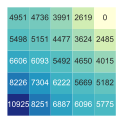

In [12]:
state_visitation = pd.Series(Counter([s%(num_cells*num_cells) for s, *_ in buffer]))
state_visitation[num_cells*num_cells-1] = 0 # terminal states are not counted in the line above
state_visitation = state_visitation.reindex(range(num_cells*num_cells))

fig, ax = plt.subplots(figsize=(2,2))
ax = sns.heatmap(state_visitation.values.reshape((num_cells,num_cells)), vmax=12000,
                 annot=True, annot_kws={"fontsize":8}, fmt='g',
                 cmap="YlGnBu", square=True, cbar=False, 
                     xticklabels=False, yticklabels=False, ax=ax)
ax.invert_yaxis()
plt.show()

Max episode length 787


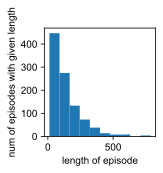

In [13]:
episode_lengths = []
_cur = 0
for _, _, _, _, done, *_ in buffer:
    _cur += 1
    if done:
        episode_lengths.append(_cur)
        _cur = 1

print('Max episode length', max(episode_lengths))

fig, ax = plt.subplots(figsize=(2,2))
plt.hist(episode_lengths)
plt.xlabel('length of episode')
plt.ylabel('num of episodes with given length')
plt.show()

In [14]:
# Online Q-learning
def _qlearn_real(run):
    seed = 10000 + run
    env_ = gridworld.MyGridNaviModuloCounter(
        num_cells=num_cells, 
        counter_limit=counter_limit, 
        seed=seed,
        num_steps=1000, # set this to a large number so effectively no limit on steps
    )
    env_.reset_task(np.array([4,4]))
    Q_, metadata_ = tabular.qlearn(
        env_, N_simulate_episodes, tabular.epsilon_greedy_policy, 
        gamma=0.95, alpha=0.5, epsilon=0.9, save_Q=True, show_tqdm=False, seed=seed)
    return metadata_['Qs'][:,0,:].max(axis=-1)

Qs_ql0 = Parallel(n_jobs=10)(delayed(_qlearn_real)(run) for run in tqdm(range(N_simulate_runs)))   

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:08<00:00,  1.29s/it]


In [15]:
# Model-based simulation of Q-learning
# assume state space is the full observation space with 25x32 states

cnt = np.zeros((5, 25*counter_limit, 25*counter_limit))
for i, row in df_data.iterrows():
    t, s, a, r, s_ = row
    cnt[int(a), int(s), int(s_)] += 1

cnt[:, 24::25,:] = 1
P = cnt / cnt.sum(axis=-1, keepdims=True)
P[:, 24::25,:] = 0

R = -0.1 * np.ones((5, 25*counter_limit, 25*counter_limit))
R[:,:,24::25] = 1

isd = np.zeros(25*counter_limit)
isd[::25] = 1
isd = isd / isd.sum(keepdims=True)

S_terminal = range(24, 25*counter_limit, 25)

def _qlearn_sim1(run):
    seed = 10000 + run
    env_ = MDP_Env(P.transpose((1,0,2)), R.transpose((1,0,2)), S_terminal, isd)
    Q_, metadata_ = tabular.qlearn(
        env_, N_simulate_episodes, tabular.epsilon_greedy_policy, 
        gamma=0.95, alpha=0.5, epsilon=0.9, save_Q=True, show_tqdm=False, seed=seed)
    return metadata_['Qs'][:,0,:].max(axis=-1)

Qs_ql1 = Parallel(n_jobs=10)(delayed(_qlearn_sim1)(run) for run in tqdm(range(N_simulate_runs)))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:21<00:00,  1.41s/it]


In [16]:
# Model-based simulation of Q-learning
# assume state space is the 25 grid cells

cnt = np.zeros((5, 25, 25*counter_limit))
for i, row in df_data.iterrows():
    t, s, a, r, s_ = row
    cnt[int(a), int(s)%25, int(s_)] += 1

cnt = np.tile(cnt, (1,counter_limit,1))
cnt[:, 24::25,:] = 1
P = cnt / cnt.sum(axis=-1, keepdims=True)
P[:, 24::25,:] = 0

R = -0.1 * np.ones((5, 25*counter_limit, 25*counter_limit))
R[:,:,24::25] = 1

isd = np.zeros(25*counter_limit)
isd[::25] = 1
isd = isd / isd.sum(keepdims=True)

S_terminal = range(24, 25*counter_limit, 25)

def _qlearn_sim2(run):
    seed = 10000 + run
    env_ = MDP_Env(P.transpose((1,0,2)), R.transpose((1,0,2)), S_terminal, isd)
    Q_, metadata_ = tabular.qlearn(
        env_, N_simulate_episodes, tabular.epsilon_greedy_policy, 
        gamma=0.95, alpha=0.5, epsilon=0.9, save_Q=True, show_tqdm=False, seed=seed)
    return metadata_['Qs'][:,0,:].max(axis=-1)

Qs_ql2 = Parallel(n_jobs=10)(delayed(_qlearn_sim2)(run) for run in tqdm(range(N_simulate_runs)))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:26<00:00,  1.47s/it]


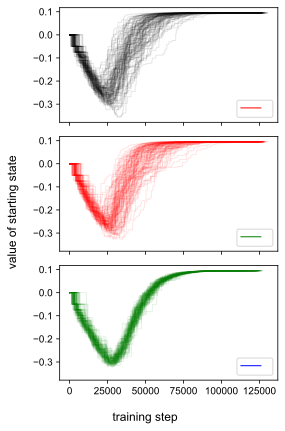

In [17]:
fig, axes = plt.subplots(3, 1, figsize=(4,6), sharex=True, sharey=True)
for run in range(N_simulate_runs):
    axes[0].plot(Qs_ql0[run], c='k', alpha=0.1, lw=1)
    axes[1].plot(Qs_ql1[run], c='r', alpha=0.1, lw=1)
    axes[2].plot(Qs_ql2[run], c='g', alpha=0.1, lw=1)

fig.supxlabel('training step')
fig.supylabel('value of starting state')
axes[0].legend([matplotlib.lines.Line2D([0], [0], color='r', lw=1)], [''], loc='lower right')
axes[1].legend([matplotlib.lines.Line2D([0], [0], color='g', lw=1)], [''], loc='lower right')
axes[2].legend([matplotlib.lines.Line2D([0], [0], color='b', lw=1)], [''], loc='lower right')
plt.tight_layout()
plt.show()

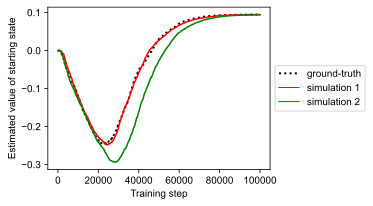

In [18]:
minlen_ql0 = min([len(Qs) for Qs in Qs_ql0])
minlen_ql1 = min([len(Qs) for Qs in Qs_ql1])
minlen_ql2 = min([len(Qs) for Qs in Qs_ql2])
minlen = 100000

meanQs_ql0 = np.array([Qs[:minlen] for Qs in Qs_ql0]).mean(axis=0)
meanQs_ql1 = np.array([Qs[:minlen] for Qs in Qs_ql1]).mean(axis=0)
meanQs_ql2 = np.array([Qs[:minlen] for Qs in Qs_ql2]).mean(axis=0)

fig, ax = plt.subplots(figsize=(4,3))
ax.plot(meanQs_ql0, c='k', ls=':', alpha=1, lw=2)
ax.plot(meanQs_ql1, c='r', alpha=1, lw=1.5)
ax.plot(meanQs_ql2, c='g', alpha=1, lw=1.5)
plt.xlabel('Training step')
plt.ylabel('Estimated value of starting state')
plt.legend([
    matplotlib.lines.Line2D([0], [0], color='k', ls=':', lw=2), 
    matplotlib.lines.Line2D([0], [0], color='r', lw=1), 
    matplotlib.lines.Line2D([0], [0], color='g', lw=1)], 
    ['ground-truth', 'simulation 1', 'simulation 2'], 
    loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [19]:
eval_steps = 100000
rmse1 = np.sqrt(np.mean(np.square(meanQs_ql1[:eval_steps] - meanQs_ql0[:eval_steps])))
rmse2 = np.sqrt(np.mean(np.square(meanQs_ql2[:eval_steps] - meanQs_ql0[:eval_steps])))

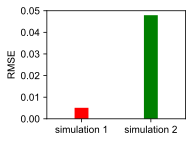

In [20]:
plt.figure(figsize=(2.5,2))
plt.bar(['simulation 1', 'simulation 2'], [rmse1, rmse2], width=0.2, color=['r', 'g'])
plt.ylabel('RMSE')
plt.ylim(0,0.05)
plt.xlim(-0.5, 1.5)
plt.show()

In [27]:
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'Times'
plt.rcParams['pdf.fonttype'] = 42

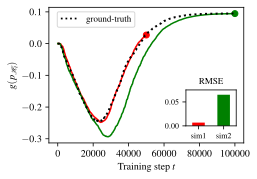

In [29]:
minlen_ql0 = min([len(Qs) for Qs in Qs_ql0])
minlen_ql1 = min([len(Qs) for Qs in Qs_ql1])
minlen_ql2 = min([len(Qs) for Qs in Qs_ql2])
minlen = 100000

meanQs_ql0 = np.array([Qs[:minlen] for Qs in Qs_ql0]).mean(axis=0)
meanQs_ql1 = np.array([Qs[:minlen] for Qs in Qs_ql1]).mean(axis=0)
meanQs_ql2 = np.array([Qs[:minlen] for Qs in Qs_ql2]).mean(axis=0)

eval_steps = 50000
rmse1 = np.sqrt(np.mean(np.square(meanQs_ql1[:eval_steps] - meanQs_ql0[:eval_steps])))
rmse2 = np.sqrt(np.mean(np.square(meanQs_ql2[:eval_steps] - meanQs_ql0[:eval_steps])))

fig, ax = plt.subplots(figsize=(3.5,2.5))
ax.plot(meanQs_ql0, c='k', ls=':', alpha=1, lw=2, zorder=10)
ax.plot(meanQs_ql1[:50000], c='r', alpha=1, lw=1.5)
ax.scatter(50000, meanQs_ql1[50000-1], c='r')
ax.plot(meanQs_ql2, c='g', alpha=1, lw=1.5)
ax.scatter(100000, meanQs_ql2[100000-1], c='g')
plt.xlabel('Training step $t$')
plt.ylabel(r'$g(p_{\mathcal{H}_t})$')
plt.legend([
    matplotlib.lines.Line2D([0], [0], color='k', ls=':', lw=1.75), 
    # matplotlib.lines.Line2D([0], [0], color='r', lw=1), 
    # matplotlib.lines.Line2D([0], [0], color='g', lw=1),
], 
    ['ground-truth', 
     # 'simulation 1', 'simulation 2',
    ], 
    loc='upper left', bbox_to_anchor=(0.02, 1), fontsize=9)
inset_ax = fig.add_axes([.67, .22, .2, .2], facecolor='w')
inset_ax.bar(['sim1', 'sim2'], [rmse1, rmse2], width=0.5, color=['r', 'g'])
inset_ax.set_title('RMSE ', fontsize=9)
inset_ax.set_ylim(0, 0.075)
inset_ax.set_xlim(-0.5, 1.5)
# inset_ax.set_xticks([])
inset_ax.tick_params(axis='both', which='major', labelsize=8)
plt.savefig('metrics.pdf', bbox_inches='tight')
plt.show()